<b> Import necessary Libraries and load the the Fake news Dataset

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

2023-03-13 16:25:19.687552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
train = pd.read_csv('train.csv')

In [6]:
import nltk
import sklearn
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

<b> Preprocessing the Fake news Dataset, importing stopwords, filling the nan values.

In [7]:
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cuongnguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [11]:
train=train.fillna('')
print('train: ','\n' ,train.isnull().sum())
newsdf = train.drop(columns='id', axis=1)
newsdf

train:  
 id          0
keyword     0
location    0
text        0
target      0
dtype: int64
test:  
 id          0
keyword     0
location    0
text        0
dtype: int64


,keyword,location,text,target
0,,,Our Deeds are the Reason of this #earthquake M...,1
1,,,Forest fire near La Ronge Sask. Canada,1
2,,,All residents asked to 'shelter in place' are ...,1
3,,,"13,000 people receive #wildfires evacuation or...",1
4,,,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
7608,,,Two giant cranes holding a bridge collapse int...,1
7609,,,@aria_ahrary @TheTawniest The out of control w...,1
7610,,,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,,,Police investigating after an e-bike collided ...,1


<b> Loading the Earthquake twitter dataset, keeping the tweets that are in English and dropping the columns we do not need.

In [12]:
eqdf = pd.read_csv('tweets.csv')
eqdf = eqdf[eqdf['language']=='en']
eqdf = eqdf.drop(['coordinates','place','source','language','hashtags','like_count','rt_count','followers_count','isVerified'], axis=1)
print('Shape of the Dataset:', eqdf.shape)
eqdf.head()


/var/folders/s5/_19scpmn5qx24kgxtpzykrz00000gn/T/ipykernel_16596/3958527838.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  eqdf = pd.read_csv('/Users/cuongnguyen/Master/Data Science/BDP/project/tweets.csv')


Shape of the Dataset: (189626, 2)


,date,content
1,2023-02-21 03:29:07+00:00,New search &amp; rescue work is in progress in...
2,2023-02-21 03:29:04+00:00,Can't imagine those who still haven't recovere...
3,2023-02-21 03:28:06+00:00,its a highkey sign for all of us to ponder ove...
5,2023-02-21 03:27:27+00:00,"See how strong was the #Earthquake of Feb 20, ..."
6,2023-02-21 03:27:11+00:00,More difficult news today on top of struggles ...


<b> Let us now load the sentiment analysis Dataset, similarly we drop the columns we do not need. We sample a 20% fraction of the data as even with the use of tensorflow the data are too much for the resources we have available. We also replace the 4 for positive sentiment to 1, the negative emotion remains 0. 

In [13]:
DATASET_ENCODING = "ISO-8859-1"
col_names = ['Popularity', 'Tweet ID', 'date', 'Flag', 'User', 'content']
sadf = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=col_names)
sadf['Popularity'] = sadf['Popularity'].replace(4,1)
sadf = sadf.drop(['Tweet ID', 'Flag', 'User'], axis=1)
sadf = sadf.sample(frac=.2)
print(sadf.shape)
sadf.head(10)

(320000, 3)


,Popularity,date,content
55005,0,Sat May 02 22:28:47 PDT 2009,"so good to reunite with my 2-time prom date, b..."
863898,1,Sat May 02 00:51:12 PDT 2009,@divasmistress {{hugs}} to you love
1534758,1,Mon Jun 15 08:16:39 PDT 2009,Still trying to get the hang of this new craze...
159519,0,Thu May 28 22:51:57 PDT 2009,Tonight meeting with my best friend and off to...
1499624,1,Sun Jun 07 18:32:58 PDT 2009,I am going to see UP is it good?
1068614,1,Fri May 29 16:30:36 PDT 2009,http://twitpic.com/67uzq - Mmm. Two of my favo...
478983,0,Mon Jun 15 08:06:15 PDT 2009,Not sure how I'm going to dance today with a s...
177884,0,Fri May 29 16:36:34 PDT 2009,Is at work
744618,0,Sun Jun 21 09:46:20 PDT 2009,Off to a prospective adopter visit for GW. Aft...
76010,0,Mon May 04 06:07:51 PDT 2009,@darrendoyle Well I watched it in a Munster pu...


In [14]:
sadf['Popularity'].unique()

array([0, 1])

<b> We now apply preprocessing and stemming to all three datasets.

In [15]:
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import re
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cuongnguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
def preprocess(text, stem=False):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [17]:
newsdf['text'] = newsdf['text'].apply(lambda x: preprocess(x))

In [18]:
eqdf['content'] =eqdf['content'].apply(lambda x: preprocess(x))

In [19]:
sadf['content'] =sadf['content'].apply(lambda x: preprocess(x))

<b> We split the data to train and test sets

In [21]:
newsX_train, newsX_test, newsY_train, newsY_test = train_test_split(newsdf['text'], newsdf['target'], test_size = 0.2, stratify=newsdf['target'], random_state=2)

In [22]:
saX_train, saX_test, saY_train, saY_test = train_test_split(sadf['content'], sadf['Popularity'], test_size=.2)

<b> We now create the tokenized vocabulary that will be fed to our CNN model later on.

In [23]:
from gensim.models import Word2Vec
Embedding_dimensions = 100
# Creating Word2Vec training dataset.
Word2vec_eq_train_data = list(map(lambda x: x.split(), eqdf['content']))

In [24]:
word2vec_model = Word2Vec(Word2vec_eq_train_data,vector_size=Embedding_dimensions,workers=8,min_count=5)

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(eqdf['content'])
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 60000


In [26]:
input_length = 60
eq_vec = pad_sequences(tokenizer.texts_to_sequences(eqdf['content']), maxlen=input_length)
newsX_train = pad_sequences(tokenizer.texts_to_sequences(newsX_train), maxlen=input_length)
newsX_test = pad_sequences(tokenizer.texts_to_sequences(newsX_test), maxlen=input_length)
saX_train  = pad_sequences(tokenizer.texts_to_sequences(saX_train) , maxlen=input_length)
saX_test = pad_sequences(tokenizer.texts_to_sequences(saX_test), maxlen=input_length)
print("newsX_train.shape:", newsX_train.shape)
print("newsX_test.shape:", newsX_test.shape)
print("saX_train.shape :", saX_train.shape)
print("saX_test.shape :", saX_test.shape)

newsX_train.shape: (6090, 60)
newsX_test.shape: (1523, 60)
saX_train.shape : (256000, 60)
saX_test.shape : (64000, 60)


<b> The embedded matrix is ready as shown below 

In [27]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (60000, 100)


<b> We create a function to evaluate the model with a confusion matrix included.

In [28]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
def model_Evaluate(model,X_test,y_test):
    
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred>=0.5, 1, 0)


    print(classification_report(y_test, y_pred))
    print('Model Score:',round(accuracy_score(y_test, y_pred),2)*100)

    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

<b> We build the model, defining its layers with a sigmoid activation function.

In [29]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [30]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
training_model = getModel()
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

2023-03-13 16:26:48.338538: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<b>The model architecture is done, we now complile the model and train it in 12 epochs on the Fake news Dataset.

In [31]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
training_model.fit(newsX_train, newsY_train, batch_size=128, validation_split=0.1, epochs=12, callbacks=callbacks, verbose=1)

Epoch 1/12


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


43/43 [==============================] - 35s 519ms/step - loss: 0.5702 - accuracy: 0.7230 - val_loss: 0.5252 - val_accuracy: 0.7422 - lr: 0.0010
Epoch 2/12
43/43 [==============================] - 22s 506ms/step - loss: 0.5213 - accuracy: 0.7517 - val_loss: 0.5207 - val_accuracy: 0.7438 - lr: 0.0010
Epoch 3/12
43/43 [==============================] - 22s 518ms/step - loss: 0.5053 - accuracy: 0.7666 - val_loss: 0.5067 - val_accuracy: 0.7471 - lr: 0.0010
Epoch 4/12
43/43 [==============================] - 20s 469ms/step - loss: 0.4979 - accuracy: 0.7718 - val_loss: 0.4846 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 5/12
43/43 [==============================] - 20s 471ms/step - loss: 0.4834 - accuracy: 0.7807 - val_loss: 0.5003 - val_accuracy: 0.7471 - lr: 0.0010
Epoch 6/12
43/43 [==============================] - 20s 470ms/step - loss: 0.4617 - accuracy: 0.7889 - val_loss: 0.4893 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 7/12
43/43 [==============================] - 20s 469ms/step - loss: 

<b> Let us now evaluate the model. It seems that the model is a bit biased towards fake news detection. The overall accuracy is adequate.

48/48 [==============================] - 5s 50ms/step
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       869
           1       0.74      0.67      0.70       654

    accuracy                           0.76      1523
   macro avg       0.76      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523

Model Score: 76.0


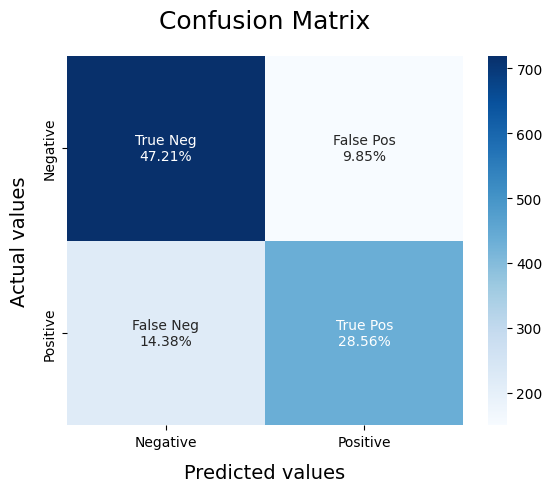

In [33]:
model_Evaluate(training_model,newsX_test,newsY_test)

<b> We will now detect the fake news on the earthquake Dataset.

In [34]:
eq_legit_pred = training_model.predict(eq_vec)
eqdf['legit_news'] = np.where(eq_legit_pred > 0.5, 1, 0)
print("eq legit prediction: ", eqdf['legit_news'])

5926/5926 [==============================] - 283s 48ms/step
eq legit prediction:  1         1
2         1
3         1
5         1
6         1
         ..
478046    1
478047    0
478049    1
478050    1
478051    1
Name: legit_news, Length: 189626, dtype: int64


<b> We apply the same training and evaluation procedure for the Sentiment analysis dataset.

In [35]:
training_model.fit(saX_train, saY_train, batch_size=128, validation_split=0.1, epochs=12, callbacks=callbacks, verbose=1)

Epoch 1/12


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


1800/1800 [==============================] - 857s 476ms/step - loss: 0.5951 - accuracy: 0.6702 - val_loss: 0.5574 - val_accuracy: 0.7061 - lr: 0.0010
Epoch 2/12
1800/1800 [==============================] - 856s 476ms/step - loss: 0.5617 - accuracy: 0.7015 - val_loss: 0.5407 - val_accuracy: 0.7195 - lr: 0.0010
Epoch 3/12
1800/1800 [==============================] - 901s 500ms/step - loss: 0.5457 - accuracy: 0.7148 - val_loss: 0.5287 - val_accuracy: 0.7301 - lr: 0.0010
Epoch 4/12
1800/1800 [==============================] - 879s 488ms/step - loss: 0.5354 - accuracy: 0.7232 - val_loss: 0.5227 - val_accuracy: 0.7363 - lr: 0.0010
Epoch 5/12
1800/1800 [==============================] - 857s 476ms/step - loss: 0.5269 - accuracy: 0.7296 - val_loss: 0.5164 - val_accuracy: 0.7413 - lr: 0.0010
Epoch 6/12
1800/1800 [==============================] - 842s 468ms/step - loss: 0.5200 - accuracy: 0.7358 - val_loss: 0.5120 - val_accuracy: 0.7427 - lr: 0.0010
Epoch 7/12
1800/1800 [=======================

2000/2000 [==============================] - 101s 50ms/step
              precision    recall  f1-score   support

           0       0.75      0.73      0.74     32022
           1       0.74      0.76      0.75     31978

    accuracy                           0.75     64000
   macro avg       0.75      0.75      0.75     64000
weighted avg       0.75      0.75      0.75     64000

Model Score: 75.0


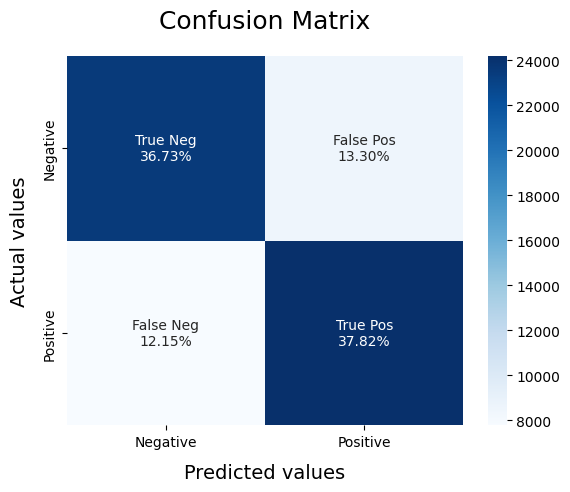

In [36]:
model_Evaluate(training_model,saX_test,saY_test)

<b> The results are similar as far as accuracy is concerned. There's seems to be no bias here.

In [37]:
eq_sentiment_pred = training_model.predict(eq_vec)
eqdf['sentiment'] = np.where(eq_sentiment_pred > 0.5, 1, 0)
print("eq sentiment pred: ", eqdf['sentiment'])

5926/5926 [==============================] - 309s 52ms/step
eq sentiment pred:  1         0
2         0
3         0
5         1
6         0
         ..
478046    0
478047    1
478049    1
478050    1
478051    0
Name: sentiment, Length: 189626, dtype: int64


<b> We now have to select the tweets that concern political reaction. We create a class and use keywords to filter correctly. We also create two more classes that could be used in answering other research questions in the future. 

In [38]:
from collections import Counter

all_text = ' '.join(eqdf['content'].values)
all_text = re.sub(r'http\S+', '', all_text)
all_text = re.sub(r'@\S+', '', all_text)
all_text = re.sub(r'#\S+', '', all_text)
words = all_text.split()
stop_words = set(stopwords.words('english'))
words = [word for word in words if not word in stop_words]
word_counts = Counter(words)
top_words = word_counts.most_common(1000)
top_words

[('turkey', 167470),
 ('earthquake', 152603),
 ('syria', 102093),
 ('people', 33086),
 ('turkeyearthquake', 27629),
 ('help', 23113),
 ('amp', 21470),
 ('turkiye', 17573),
 ('7', 16885),
 ('earthquakes', 14759),
 ('deprem', 14023),
 ('prayforturkey', 13488),
 ('prayers', 13475),
 ('rescue', 12600),
 ('may', 12393),
 ('8', 12074),
 ('allah', 11956),
 ('affected', 11651),
 ('aid', 11454),
 ('magnitude', 11431),
 ('turkeyquake', 11222),
 ('turkeysyriaearthquake', 10754),
 ('2', 10713),
 ('earthquakeinturkey', 10327),
 ('rubble', 10068),
 ('turkish', 9026),
 ('5', 8859),
 ('victims', 8693),
 ('please', 8678),
 ('pray', 8643),
 ('us', 8522),
 ('rkiye', 8517),
 ('km', 8481),
 ('syriaearthquake', 8300),
 ('death', 8288),
 ('disaster', 8213),
 ('hit', 8190),
 ('4', 8022),
 ('devastating', 7857),
 ('toll', 7726),
 ('time', 7553),
 ('support', 7457),
 ('000', 7450),
 ('6', 7418),
 ('1', 7215),
 ('need', 6923),
 ('3', 6847),
 ('ago', 6847),
 ('world', 6428),
 ('relief', 6318),
 ('lebanon', 6288),

In [39]:
classes = {
    'Help': ['help', 'assistance', 'support', 'donate','donor', 'aid', 'relief', 'volunteer','humanitarian','rescue'],
    'Political response': ['government', 'political', 'response','erdogan', 'minister','prime','president'],
    'Infrastructure damage': ['building', 'bridge', 'road', 'power', 'water', 'gas', 'telecommunications'],
}

def classify_tweet(tweet_text):
    for class_name, keywords in classes.items():
                for keyword in keywords:
                   if keyword in tweet_text:
                     return class_name
    return 'Other'

eqdf['Class'] = eqdf['content'].apply(classify_tweet)
eqdf.to_csv('tweet_data_labeled.csv', index=False)

In [40]:
eqdf = pd.read_csv('tweet_data_labeled.csv')
eqdf.head(10)

,date,content,legit_news,sentiment,Class
0,2023-02-21 03:29:07+00:00,new search amp rescue work progress hatay two ...,1,0,Help
1,2023-02-21 03:29:04+00:00,imagine still recovered previous tragedy amp l...,1,0,Other
2,2023-02-21 03:28:06+00:00,highkey sign us ponder actions return merciful...,1,0,Other
3,2023-02-21 03:27:27+00:00,see strong earthquake feb 20 2023 hatay turkey...,1,1,Other
4,2023-02-21 03:27:11+00:00,difficult news today top struggles already fac...,1,0,Help
5,2023-02-21 03:26:30+00:00,another earthquake southern turkey,1,0,Other
6,2023-02-21 03:26:18+00:00,three people confirmed died 6 4 magnitude eart...,1,0,Other
7,2023-02-21 03:26:11+00:00,6 4 magnitude quake shakes turkey syria border...,1,0,Other
8,2023-02-21 03:25:13+00:00,new 6 3 earthquake hits turkey syria border ki...,1,0,Other
9,2023-02-21 03:25:12+00:00,latest earthquake turkey impact disaster recov...,1,0,Other


<b>Filter the Data to keep only the tweets about the political response

In [41]:
df2 = eqdf[eqdf['Class']=='Political response']
eqdf = df2['content']
df2.head(10)

,date,content,legit_news,sentiment,Class
10,2023-02-21 03:24:33+00:00,indian media show postive news great noble qua...,1,1,Political response
49,2023-02-21 02:37:49+00:00,turkish interior minister suleyman soylu says ...,1,0,Political response
64,2023-02-21 02:15:14+00:00,turkish interior minister suleyman soylu says ...,1,0,Political response
194,2023-02-21 00:26:16+00:00,today headlines 1 3 presidentbiden visited ukr...,1,0,Political response
214,2023-02-21 00:04:48+00:00,kiddle getting angry turkey amp governments ge...,1,0,Political response
237,2023-02-20 23:37:47+00:00,turkey build nearly 2 lac homes quake hit regi...,1,0,Political response
283,2023-02-20 23:05:39+00:00,health minister koca 294 injured two earthquak...,1,0,Political response
566,2023-02-20 20:31:58+00:00,moment earthquake change hatay captured car da...,1,0,Political response
598,2023-02-20 20:22:05+00:00,moment earthquake change hatay captured car da...,1,0,Political response
619,2023-02-20 20:17:24+00:00,moment earthquake change hatay captured car da...,1,0,Political response


<b>Filter Data that are fake and real news into two new datasets


In [42]:
df3 = df2[df2['legit_news']== 0]
df4 = df2[df2['legit_news']== 1]

<b>Decode the 0,1 sentiment into Positive and negative for all three datasets

In [43]:
from collections import Counter
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
decode_map = {0: "NEGATIVE", 1: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]


df2['sentiment'] = df2['sentiment'].apply(lambda x: decode_sentiment(x))
df3['sentiment'] = df3['sentiment'].apply(lambda x: decode_sentiment(x))
df4['sentiment'] = df4['sentiment'].apply(lambda x: decode_sentiment(x))


Popularity_cnt1 = Counter(df2['sentiment'])
Popularity_cnt2 = Counter(df3['sentiment'])
Popularity_cnt3 = Counter(df4['sentiment'])

/var/folders/s5/_19scpmn5qx24kgxtpzykrz00000gn/T/ipykernel_16596/39307896.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['sentiment'] = df3['sentiment'].apply(lambda x: decode_sentiment(x))
/var/folders/s5/_19scpmn5qx24kgxtpzykrz00000gn/T/ipykernel_16596/39307896.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['sentiment'] = df4['sentiment'].apply(lambda x: decode_sentiment(x))


<b>Plot a bar chart for each dataset to showcase the sentiment analysis on "Real & Fake News" , "Real News" and "Fake News" respectively.

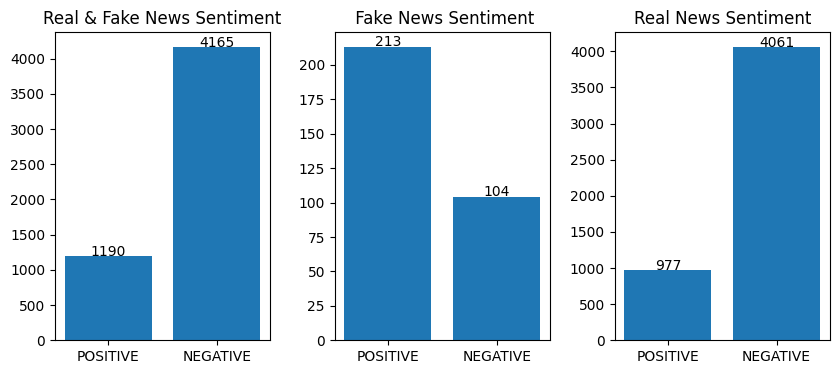

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
for i, (data, ax) in enumerate(zip([Popularity_cnt1, Popularity_cnt2, Popularity_cnt3], axs)):
    ax.bar(data.keys(), data.values())
    ax.set_title('Plot {}'.format(i+1))
    for j, v in enumerate(data.values()):
        ax.text(j, v+0.5, str(v), ha='center')
axs[0].set_title('Real & Fake News Sentiment')
axs[1].set_title(' Fake News Sentiment')
axs[2].set_title('Real News Sentiment')
plt.subplots_adjust(wspace=0.3)
plt.show()